# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 13.1 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [25]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Extracting Annotations from XML Format

In [4]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/pomeranian_134.xml'

In [6]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [7]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [8]:
extract_annotation(xml_files[0])

{'file': 'pomeranian_134.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 300, 'height': 248, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 24,
   'top': 7,
   'width': 80,
   'height': 94}]}

# Visualize Data

In [9]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 20)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

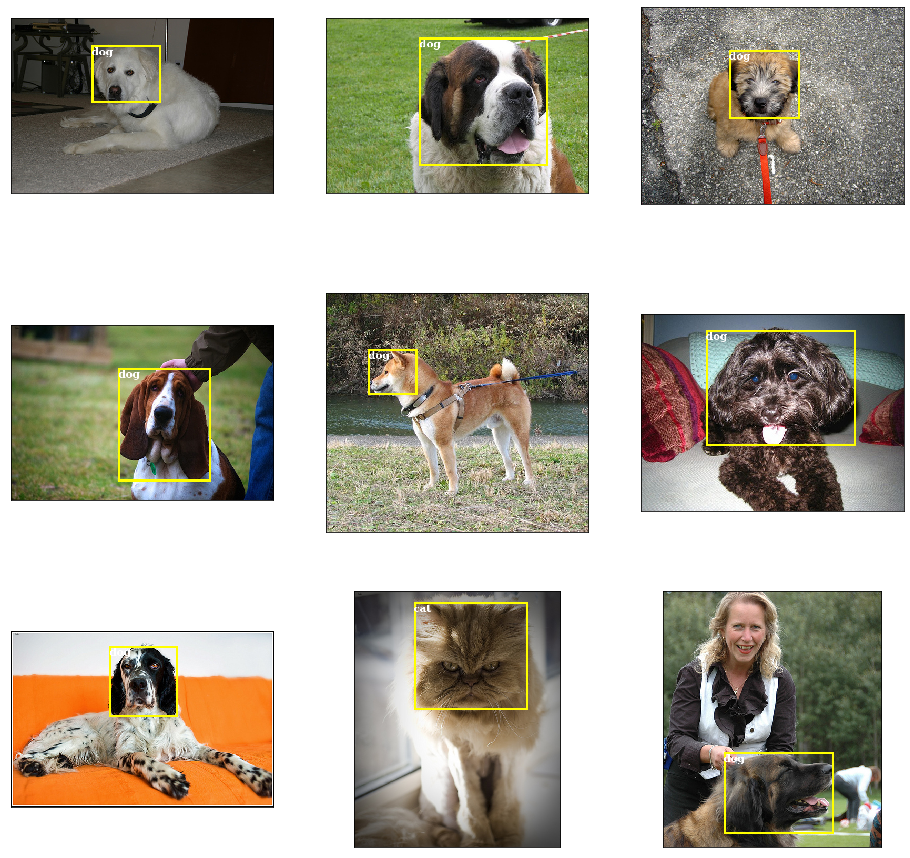

In [19]:
show_random_annotations(plt)

# SageMaker Setup

In [44]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdatadogcat'
training_image = get_image_uri(boto3.Session().region_name,
                               'object-detection',
                               repo_version='latest' )
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [45]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [46]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [47]:
for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:01<00:00, 2231.53it/s]


In [48]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [49]:
print(len(train_annots), len(train_images))

2762 2762


In [50]:
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

# Uploading Data to S3

In [54]:
sess = sagemaker.Session()
print('uploading data ...')
s3_train_path = sess.upload_data(path ='train', bucket = bucket_name, key_prefix = 'train')

print('training images uploaded')
s3_validation_path = sess.upload_data(path = 'validation', bucket = bucket_name ,
                                      key_prefix = 'validation')
print('validation images are uploaded')
s3_train_annotation = sess.upload_data(path ='train_annotation', bucket = bucket_name, 
                                     key_prefix = 'train_annotation')

print('training annotation uploaded')
s3_validation_annotation = sess.upload_data(path = 'validation_annotation', bucket = bucket_name ,
                                      key_prefix = 'validation_annotation')
print('validation annotation are uploaded')

uploading data ...
training images uploaded
validation images are uploaded
training annotation uploaded
validation annotation are uploaded


In [55]:
s3_validation_annotation

's3://petsdatadogcat/validation_annotation'

# SageMaker Estimator

In [77]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    train_instance_type= 'ml.m5.xlarge',
    train_instance_count =1,
    train_volume_size = 100,
     train_max_run = 36000,
     input_mode = 'File',
     output_path ='s3://petsdatadogcat/output',
     sagemaker_session = sess
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [70]:
model.set_hyperparameters(
 base_network = 'resnet-50',
 num_classes = 2,
 use_pretrained_model = 1,
 mini_batch_size = 16,
 epochs = 15,
 learning_rate = 0.001,
 optimizer = 'sgd',
 lr_scheduler_step = '10',
 lr_scheduler_factor = 0.1,
 momentum = 0.9,
 weight_decay = 0.0005,
 overlap_threshold = 0.5,
 nms_threshold = 0.45,
 image_shape = 512,
 num_training_samples = len(train_annots)
)

# Data Channels

In [71]:
from sagemaker.session import s3_input
train_data = s3_input(s3_train_path, distribution = 'FullyReplicated', 
                                       content_type = 'application/x-image', 
                      s3_data_type = 'S3Prefix')
validation_data = s3_input(s3_validation_path, distribution = 'FullyReplicated', 
                                       content_type = 'application/x-image', 
                      s3_data_type = 'S3Prefix')
train_annotation_data = s3_input(s3_train_annotation, distribution = 'FullyReplicated', 
                                       content_type = 'application/x-image', 
                      s3_data_type = 'S3Prefix')
validation__annotation_data = s3_input(s3_validation_annotation, distribution = 'FullyReplicated', 
                                       content_type = 'application/x-image', 
                      s3_data_type = 'S3Prefix')


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [73]:
data_channels = {
    'train' : train_data,
     'validation' : validation_data,
     'train_annotation' : train_annotation_data,
     'validation_annotation' : validation__annotation_data
    
}

In [74]:
data_channels

{'train': <sagemaker.inputs.s3_input at 0x7f8f45cb6da0>,
 'validation': <sagemaker.inputs.s3_input at 0x7f8f45cb6208>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7f8f45cb6668>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7f8f45cb6ac8>}

# Model Training

In [78]:
model.fit(inputs = data_channels, logs = True)


ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: Instance type ml.m5.xlarge is not supported by algorithm object-detection; only GPU instances are supported.

# Deploy Model

# Predictions

In [6]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

NameError: name 'os' is not defined

In [5]:
index = 0

image_path = os.path.join(image_dir, images[index])
image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)

preds = results['prediction']

NameError: name 'os' is not defined

In [2]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 30)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

NameError: name 'Image' is not defined

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [7]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

NameError: name 'sagemaker' is not defined